## Bayesian Optimization：Hyperopt工具包

这里为大家简单介绍贝叶斯优化以及Hyperopt工具包的使用，附上部分参考资料：

[贝叶斯优化](https://sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf) [Hyperopt](https://jaberg.github.io/hyperopt/) 

### 贝叶斯优化所需四大部分：

-  1. Objective 目标函数
-  2. Domain space: 指定参数空间
-  3. Hyperparameter optimization function: 可以选择的采样算法，随机或者贝叶斯优化
-  4. Trials: 记录结果的保存



In [2]:
# Good old pandas and numpy
import pandas as pd
import numpy as np
%matplotlib inline

# Unfortunately I'm still using matplotlib for graphs
import matplotlib.pyplot as plt
import seaborn as sns

#1 pip install hyperopt
#2 pip uninstall networkx
#3 pip install networkx==1.11

### Objective


自定义一下我们的目标，这里得有一个最小值

In [3]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

Minimum of -219.8012 occurs at 4.8779


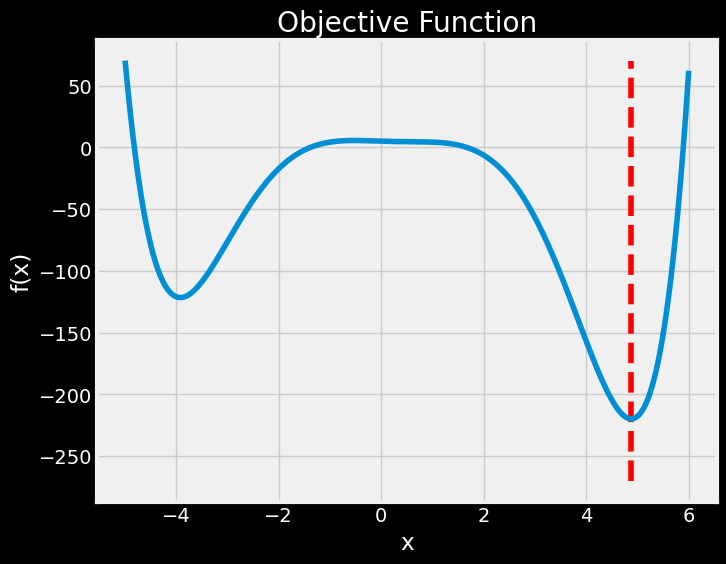

In [4]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

# Domain

参数的取值范围

In [7]:
from hyperopt import hp

# Create the domain space
space = hp.uniform('x', -5, 6)

We can draw samples from the space using a Hyperopt utility. This is useful for visualizing a distribution.

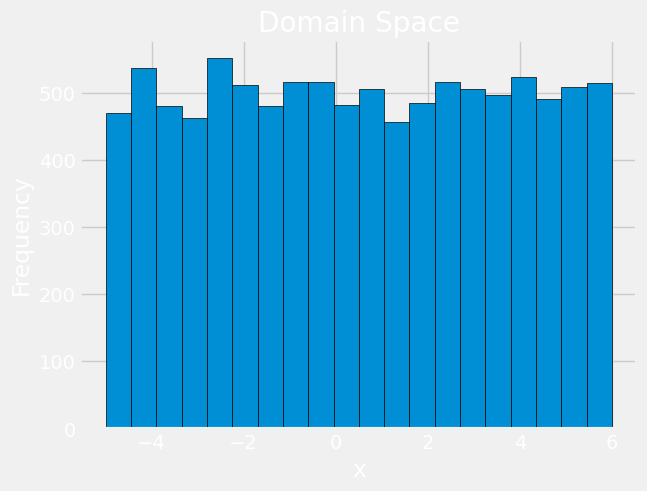

In [8]:
from hyperopt.pyll.stochastic import sample


samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

### Hyperparameter Optimization Algorithm

随机或者贝叶斯优化

In [10]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

### Trials

保存我们的实验结果

In [9]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()

### 来跑一下看看

In [19]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000)

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000)
print(rand_best)

100%|██████████| 2000/2000 [00:04<00:00, 474.62trial/s, best loss: -219.8011454917245] 
{'x': np.float64(4.8774604821572485)}
100%|██████████| 2000/2000 [00:01<00:00, 1449.41trial/s, best loss: -219.80101448255957]
{'x': np.float64(4.876923314148787)}


看看时间效率.

In [25]:
%%timeit -n 3 #执行3次
# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=200)

100%|██████████| 200/200 [00:00<00:00, 1813.81trial/s, best loss: -219.7968558954892]
113 ms ± 3.81 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [16]:
%%timeit -n 3

# Run 2000 evals with the random algorithm
best = fmin(fn=objective, space=space, algo=rand_algo, max_evals=200)

100%|██████████| 200/200 [00:00<00:00, 7700.28trial/s, best loss: -219.6725110336791]
28 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


贝叶斯优化还需要花时间去找下次更好的值

### 贝叶斯优化结果展示

In [26]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

,loss,iteration,x
0,1.953808,4,-1.246184
1,5.039413,5,-0.029934
2,-83.896368,6,-4.469757
3,5.174116,7,-0.801836
4,2.330427,8,1.443663


In [21]:
tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.head()

/var/folders/fy/jcrzfgwd21bddbf9hm36bz0c0000gn/T/ipykernel_11541/3274103927.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
/var/folders/fy/jcrzfgwd21bddbf9hm36bz0c0000gn/T/ipykernel_11541/3274103927.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')


,loss,iteration,x,rolling_average_x,rolling_average_loss
0,1.953808,4,-1.246184,1.561347,-70.50971
1,5.039413,5,-0.029934,1.561347,-70.50971
2,-83.896368,6,-4.469757,1.561347,-70.50971
3,5.174116,7,-0.801836,1.561347,-70.50971
4,2.330427,8,1.443663,1.561347,-70.50971


迭代过程趋势

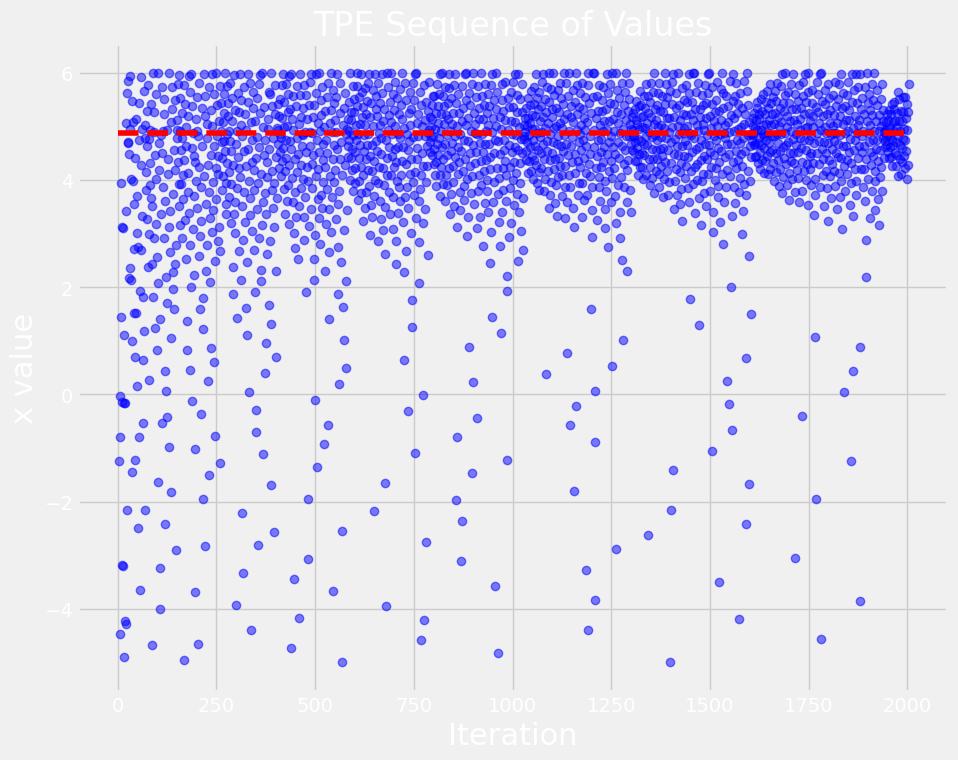

In [22]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

都选了哪些值

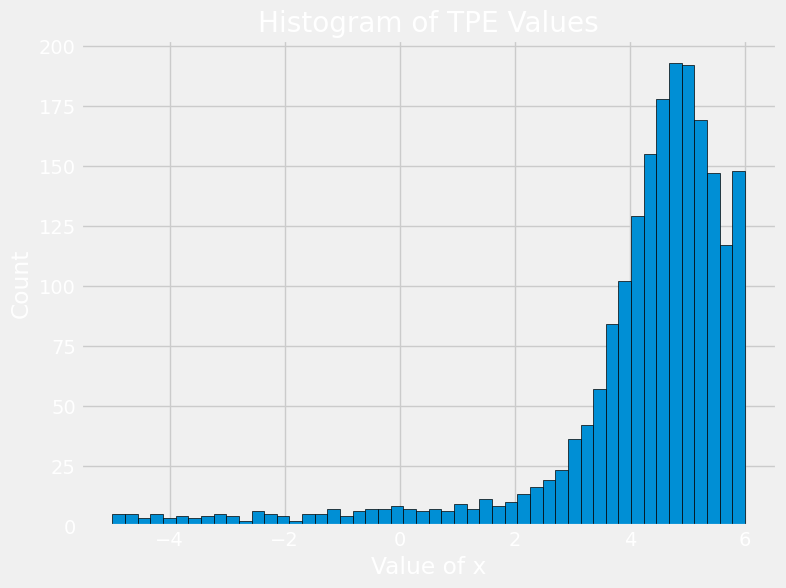

In [23]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

### 随机优化结果展示


In [24]:
rand_results = pd.DataFrame({'loss': [x['loss'] for x in rand_trials.results], 'iteration': rand_trials.idxs_vals[0]['x'],
                            'x': rand_trials.idxs_vals[1]['x']})
                            
rand_results.head()

,loss,iteration,x
0,-2.343457,0,1.812602
1,-46.179649,1,-2.558260
2,-175.472540,2,4.174754
3,5.521069,3,-0.601928
4,-111.684184,4,-3.556821


很好，很随机。。。

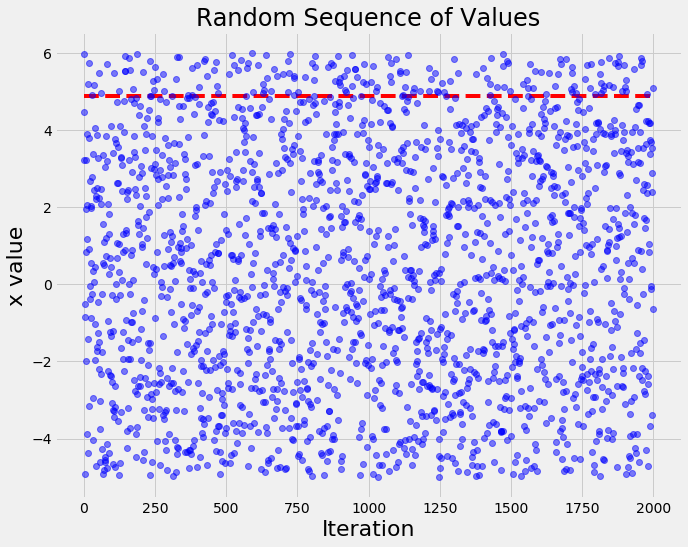

In [16]:
plt.figure(figsize = (10, 8))
plt.plot(rand_results['iteration'], rand_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('Random Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

Best Loss of -219.8012 occured at iteration 235


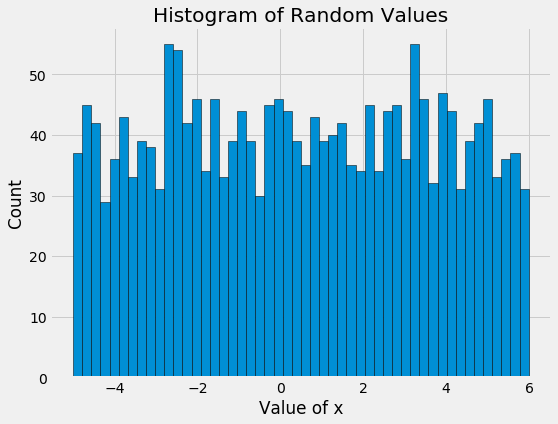

In [17]:
# Sort with best loss first
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()

plt.figure(figsize = (8, 6))
plt.hist(rand_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of Random Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

# Print information
print('Best Loss of {:.4f} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))

### 选择更合适的参数空间

这会使得我们做起优化来更容易！


In [18]:
# Normally distributed space
space = hp.normal('x', 4.9, 0.5)

有点开挂了。。。但是经验值这个东西还是存在的！

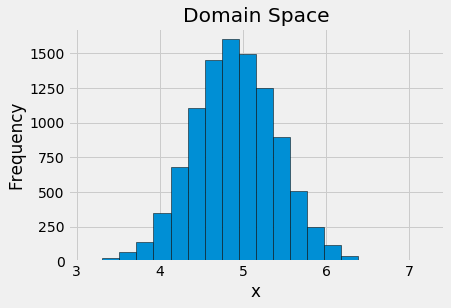

In [19]:
samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

### 跑一次不容易，多来参考点信息

在字典中放入更多的信息

In [22]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [23]:
def objective(x):
    """Objective function to minimize with smarter return values"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Evaluate the function
    start = timer()
    loss = f(x) * 0.05
    end = timer()
    
    # Calculate time to evaluate
    time_elapsed = end - start
    
    results = {'loss': loss, 'status': STATUS_OK, 'x': x, 'time': time_elapsed}
    
    # Return dictionary
    return results

再跑一次

In [24]:
# New trials object
trials = Trials()

# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, trials=trials, 
                max_evals=2000, rstate= np.random.RandomState(120))

结果中的信息更丰富了

In [25]:
results = trials.results
results[:2]

[{'loss': -189.3682041842684,
  'status': 'ok',
  'time': 3.925334449839113e-05,
  'x': 5.312379584994148},
 {'loss': -219.325099632915,
  'status': 'ok',
  'time': 2.503111823060067e-05,
  'x': 4.8166084516702705}]

得到结果

In [26]:
# Results into a dataframe
results_df = pd.DataFrame({'time': [x['time'] for x in results], 
                           'loss': [x['loss'] for x in results],
                           'x': [x['x'] for x in results],
                            'iteration': list(range(len(results)))})

# Sort with lowest loss on top
results_df = results_df.sort_values('loss', ascending = True)
results_df.head()

,time,loss,x,iteration
956,0.000030,-219.801204,4.878152,956
1316,0.000029,-219.801204,4.878111,1316
402,0.000027,-219.801204,4.878189,402
914,0.000022,-219.801203,4.878064,914
1954,0.000031,-219.801203,4.878222,1954


这回都尝试了哪些值呢？

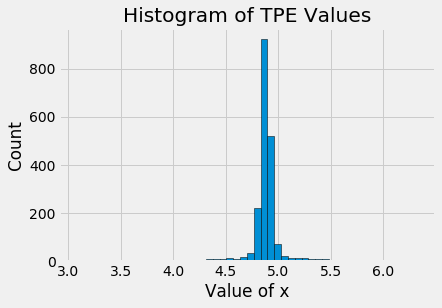

In [27]:
plt.hist(results_df['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

不同的参数空间，开挂了。。。


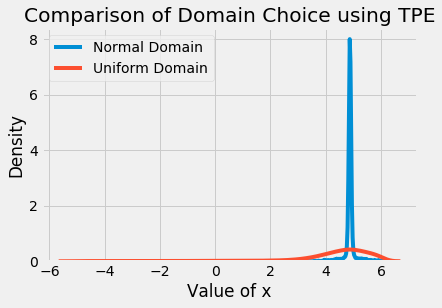

In [28]:
sns.kdeplot(results_df['x'], label = 'Normal Domain')
sns.kdeplot(tpe_results['x'], label = 'Uniform Domain')
plt.legend(); plt.xlabel('Value of x'); plt.ylabel('Density'); plt.title('Comparison of Domain Choice using TPE');